In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import pyross
import time 

In [2]:
# correct params
beta  = 0.02        # infection rate
gIa   = 1./7        # recovery rate of asymptomatic infectives
gIs   = 1./7        # recovery rate of asymptomatic infectives
gE    = 0.1         # exposed to infected rate
fsa   = 1         # the self-isolation parameter (assumed to be known)

# set the age structure
M=16  ## number of age classes
Ni = pyross.utils.getPopulation(country='UK', M=M)
min_age = 2.5; max_age = 77.5; age = np.linspace(min_age,max_age, M)
N = np.sum(Ni)

CH, CW, CS, CO = pyross.contactMatrix.UK()
def contactMatrix(t):
    return CH + CW + CS + CO

alpha = 0.66*np.exp(-age/50.5) 

Tf = 800
Nf = Tf+1

parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs, 'gE':gE, 'fsa':fsa}
true_parameters = parameters

S0 = Ni
Ia0 = np.zeros((M))
Ia0[2] += 10
S0[2] -= 10

Is0 = np.zeros((M))
E0 = np.zeros((M))

# use pyross stochastic to generate traj and save 
sto_model = pyross.stochastic.SEIR(parameters, M, Ni)
data = sto_model.simulate(S0, E0, Ia0, Is0, contactMatrix, Tf, Nf, method='tau_leaping')

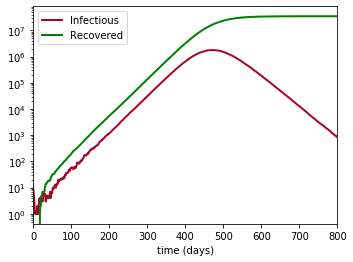

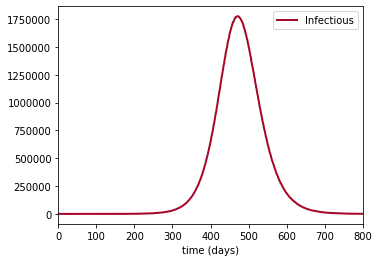

In [3]:
## Plot Results ##

Infectious = np.sum((sto_model.Is(data) + sto_model.Ia(data)), axis=1) 
R = np.sum(sto_model.R(data), axis=1)

plt.figure(figsize=(12, 4)); plt.subplot(121) 
plt.semilogy(data['t'], Infectious,  color = "#A60628", label = 'Infectious' ,lw = 2)
plt.semilogy(data['t'], R,              color = 'green',   label = 'Recovered'  ,lw = 2)
plt.xlabel('time (days)');       
plt.xlim(0,Tf);  
# plt.ylim(1e-7,2)
plt.legend()
plt.show()

plt.figure(figsize=(12, 4)); plt.subplot(121) 
plt.plot(data['t'], Infectious,  color = "#A60628", label = 'Infectious' ,lw = 2)
plt.xlabel('time (days)');       
plt.xlim(0,Tf);  
# plt.ylim(1e-7,2) 
plt.legend()
plt.show()

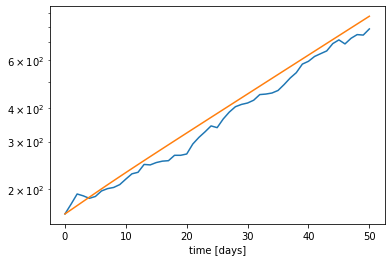

In [4]:
# load the data and rescale to intensive variables 
N_start = 150
Tf_inference = 50
Nf_inference = Tf_inference + 1

x = data['X'].astype('float')
x = x[N_start:N_start+Nf_inference]

# initialise the estimator 
estimator = pyross.inference.SEIR(parameters, M, Ni)


# make a fltr to get N-R and Is for each age class 
fltr=np.kron([[1, 1, 1, 1], [0, 0, 0, 1]], np.identity(M))
obs=np.einsum('ij,kj->ki', fltr, x)
x0=x[0]

# Compare the deterministic trajectory and the stochastic trajectory with the same 
# initial conditions and parameters 
estimator.set_det_model(parameters)
estimator.set_contact_matrix(contactMatrix)
time_points = np.linspace(0, Tf_inference, Nf_inference)
xm = estimator.integrate(x0, 0, Tf_inference, Nf_inference)

plt.semilogy(np.sum(obs[:, -M:], axis=1))
plt.semilogy(np.sum(np.einsum('ij,kj->ki', fltr, xm)[:, -M:], axis=1))
plt.xlabel("time [days]")
plt.show()

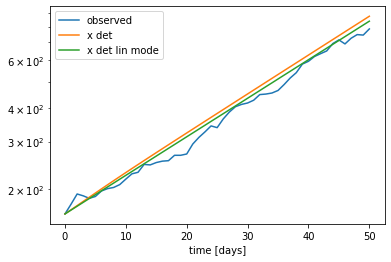

In [5]:
# test the approximation of the initial conditions by v 
zero_state = np.zeros((4*M))
zero_state[:M] = Ni 
dev = x0 - zero_state 
c = np.linalg.norm(dev, ord=1)

init_priors = {
    'lin_mode_coeff':{
        'fltr': np.repeat([False, True, True, False], M), # Use fastest lin modes to guess E, Ia 
        'mean': c, 
        'std': c, 
        'bounds': [c*0.1, c*10]
    }
}


x0_approx = estimator.get_mean_inits(init_priors, obs[0], fltr)

xm_approx = estimator.integrate(x0_approx, 0, Tf_inference, Nf_inference)

plt.semilogy(np.sum(obs[:, -M:], axis=1), label='observed')
plt.semilogy(np.sum(np.einsum('ij,kj->ki', fltr, xm)[:, -M:], axis=1), label='x det')
plt.semilogy(np.sum(np.einsum('ij,kj->ki', fltr, xm_approx)[:, -M:], axis=1), label='x det lin mode')
plt.xlabel("time [days]")
plt.legend()
plt.show()

In [6]:
# compute -log_p for the original (correct) parameters 
start_time = time.time() 
parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa,'gIs':gIs, 'gE':gE, 'fsa':fsa}

logp = estimator.minus_logp_red(parameters, x0_approx, obs, fltr, Tf_inference, contactMatrix, tangent=True)
end_time = time.time()
print(logp) 
print(end_time - start_time)

3344.4891018983176
0.5265450477600098


In [7]:
# make parameter guesses and set up bounds for each parameter 
eps = 1e-3

param_priors = {
    'beta':{
        'mean': 0.03, 
        'std': 0.03, 
        'bounds': (eps, 1)
    }, 
    'gIa':{
        'mean': 0.13, 
        'std': 0.02, 
        'bounds': (eps, 1)
    }, 
    'gIs':{
        'mean': 0.15, 
        'std': 0.02, 
        'bounds': (eps, 1)
    }, 
    'gE':{
        'mean': 0.11, 
        'std': 0.02, 
        'bounds': (eps, 0.2)
    }
}

# optimisation parameters 
ftol = 1e-6 # the relative tol in (-logp)  

start_time = time.time()
params = estimator.latent_infer_parameters(obs, fltr, Tf_inference, contactMatrix, 
                                            param_priors, init_priors, 
                                            tangent=True,
                                            enable_global=True, 
                                            cma_population=16,
                                            global_max_iter=100, global_atol=10, 
                                            local_max_iter=200,                  
                                            verbose=True, ftol=ftol) 
end_time = time.time()
print(end_time - start_time)

Starting global minimisation ...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 5 (seed=3680941143, Fri Jul  2 13:28:27 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 3.658958205765573e+03 1.0e+00 1.19e+00  2e-02  3e+03 0:02.6
    2     32 3.469183806672654e+03 1.6e+00 1.23e+00  2e-02  3e+03 0:06.7
    3     48 3.479889539856116e+03 2.0e+00 1.45e+00  3e-02  4e+03 0:12.4
    5     80 3.432229610639363e+03 2.8e+00 1.41e+00  2e-02  3e+03 0:16.3
    7    112 3.475100744414304e+03 3.0e+00 1.19e+00  2e-02  3e+03 0:20.8
   10    160 3.392548345405230e+03 3.6e+00 9.20e-01  1e-02  2e+03 0:26.3
   14    224 3.356852344964695e+03 5.1e+00 1.13e+00  1e-02  2e+03 0:32.7
   19    304 3.363873821771514e+03 1.0e+01 8.81e-01  6e-03  1e+03 0:40.4
   24    384 3.353601315187278e+03 1.4e+01 4.97e-01  3e-03  4e+02 0:48.5
   30    480 3.345946840408024e+03 1.9e+01 5.00e-01  2e-03  4e+02 0:58.4
   37    592 3.341191815860371e+03 3.7e+01 5.03e-01  1e-03  2e+02 1:09

In [8]:
##### print the correct params and best estimates 
print('True parameters')
parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs, 'gE':gE,'fsa':fsa}
x0 = x[0]
logp = estimator.minus_logp_red(parameters, x0, obs, fltr, Tf_inference, contactMatrix)
print(parameters, logp)

print('\nTrue initial conditions: ') 
print((x0).astype('int'))
print('R initial = ', (Ni - np.sum(x0.reshape((4, M)), axis=0)))

best_estimates = params['map_params_dict']
map_x0 = params['map_x0']

estimator.set_params(best_estimates)
logp = estimator.minus_logp_red(best_estimates, map_x0, obs, fltr, Tf_inference, contactMatrix)

print('\nBest estimates')
print(best_estimates, logp)


print('\nInferred initial conditions: ') 
print((map_x0).astype('int'))
print('R initial = ', (Ni - np.sum(map_x0.reshape((4, M)), axis=0)).astype('int'))

True parameters
{'alpha': array([0.62812229, 0.56891156, 0.51528239, 0.46670865, 0.42271377,
       0.38286612, 0.34677477, 0.31408561, 0.28447793, 0.25766126,
       0.2333725 , 0.21137334, 0.19144797, 0.17340089, 0.15705503,
       0.14225004]), 'beta': 0.02, 'gIa': 0.14285714285714285, 'gIs': 0.14285714285714285, 'gE': 0.1, 'fsa': 1} 3320.4583770171607

True initial conditions: 
[3950979 4114163 3884507 3684240 4120126 4510193 4683505 4519797 4270665
 4353737 4674810 4463322 3799433 3406953 3329442 2343947      14      17
      31      71      37      36      35      35      30      36      31
      32      13       9      16       4      11       6      13      26
       7       6       8       6       6       6       1       5       3
       1       2       0       5       4       7      19      14      16
      13      16      12      15       9      12      12       3       5
       0]
R initial =  [ 37.  47.  58. 178.  85.  94.  75.  79.  72. 100.  67.  76.  24.  24.
  31.  10.

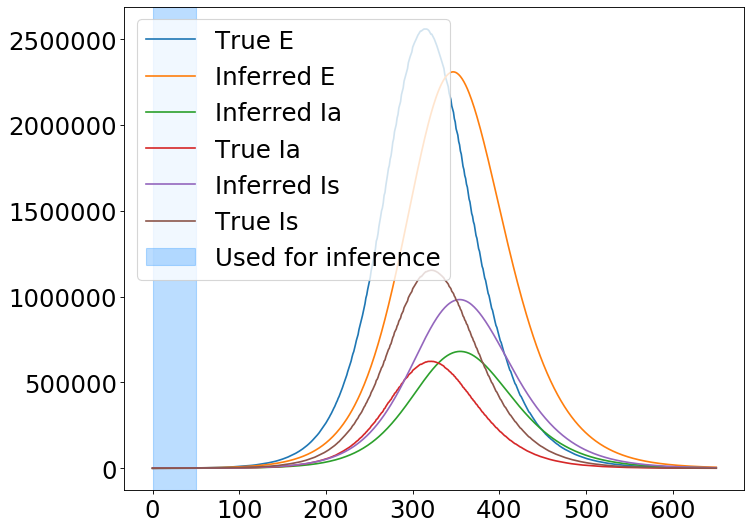

In [9]:
# plot the guessed trajectory and the true trajectory
Tf = 800
Nf = Tf+1

estimator.set_params(best_estimates)
estimator.set_det_model(best_estimates)
estimator.set_det_method('LSODA') # use more stable solver to integrate over the whole traj
x_det = estimator.integrate(x0, 0, Tf-N_start, Nf-N_start)
x = data['X'][N_start:]
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})
plt.plot(np.sum(x[:,M:2*M], axis=1), label='True E')
plt.plot(np.sum(x_det[:, M:2*M], axis=1), label='Inferred E')
plt.plot(np.sum(x_det[:, 2*M:3*M], axis=1), label='Inferred Ia')
plt.plot(np.sum(x[:,2*M:3*M], axis=1), label='True Ia')
plt.plot(np.sum(x_det[:, 3*M:], axis=1), label='Inferred Is')
plt.plot(np.sum(x[:,3*M:], axis=1), label='True Is')
plt.axvspan(0, Tf_inference, 
           label='Used for inference',
           alpha=0.3, color='dodgerblue')
plt.legend()
plt.show()